# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto¶

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 2.  Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1WScarborough(Steeles West / L'Amoreaux Wes...,\nM2ANot assigned\n\n,M9HNot assigned
freq,1,1,1


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [10]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1WScarborough(Steeles West / L'Amoreaux Wes...,\nM2ANot assigned\n\n,M9HNot assigned
freq,1,1,1


In [12]:
print(df_2.shape)
df_2.head()

(20, 3)


,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [14]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.648690,-79.385440
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.810230,-79.220380
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.789480,-79.176140
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.763430,-79.178200
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.767480,-79.228290
5,\nM1HScarborough(Cedarbrae)\n\n,\nM2HNorth York(Hillcrest Village)\n\n,M9HNot assigned,43.741672,-79.232538
6,\nM1JScarborough(Scarborough Village)\n\n,\nM2JNorth York(Fairview / Henry Farm / Oriole...,M9JNot assigned,43.738650,-79.216990
7,\nM1KScarborough(Kennedy Park / Ionview / East...,\nM2KNorth York(Bayview Village)\n\n,M9KNot assigned,43.648690,-79.385440
8,\nM1LScarborough(Golden Mile / Clairlea / Oakr...,\nM2LNorth York(York Mills / Silver Hills)\n\n,M9LNorth York(Humber Summit),43.698830,-79.279120
9,\nM1MScarborough(Cliffside / Cliffcrest / Scar...,\nM2MNorth York(Willowdale / Newtonbrook)\n\n,M9MNorth York(Humberlea / Emery),43.726420,-79.232970


In [24]:
from geopy.geocoders import Nominatim
address = 'Scarborough,Toronto'
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


### 3. Map of Scarborough

In [61]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [27]:
from geopy.geocoders import Nominatim
address = 'Scarborough,Toronto'
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [28]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [29]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [30]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [32]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
1,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
2,New York Fries - Scarborough TC,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.775135,-79.256858
3,lululemon athletica,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775517,-79.258423
4,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",43.775102,-79.257115


### 5. Categories of Nearby Venues/Locations

In [33]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
2,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
3,lululemon athletica,Clothing Store,43.775517,-79.258423
4,Subway,Sandwich Place,43.775102,-79.257115


In [34]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Restaurant             5
Clothing Store         5
Coffee Shop            4
Sandwich Place         2
Pharmacy               2
Jewelry Store          2
Department Store       2
Gas Station            2
Movie Theater          1
American Restaurant    1
Name: categories, dtype: int64

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

M9AEtobicoke(Islington Avenue)
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood)
M9ENot assigned
M9GNot assigned
M9HNot assigned
M9JNot assigned
M9KNot assigned
M9LNorth York(Humber Summit)
M9MNorth York(Humberlea / Emery)
M9NYork(Weston)
M9PEtobicoke(Westmount)
M9REtobicoke(Kingsview Village / St. Phillips / Martin Grove Gardens / Richview Gardens)
M9SNot assigned
M9TNot assigned
M9VEtobicoke(South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)
M9WEtobicokeNorthwest(Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
M9XNot assigned
M9YNot assigned
M9ZNot assigned


In [37]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 107 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
M9AEtobicoke(Islington Avenue),100,100,100,100,100,100
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale),13,13,13,13,13,13
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood),6,6,6,6,6,6
M9ENot assigned,6,6,6,6,6,6
M9GNot assigned,4,4,4,4,4,4


### One Hot Encoding of Features

In [38]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,American Restaurant,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Dessert Shop,Discount Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food Court,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hong Kong Restaurant,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Moving Target,Museum,Neighborhood,New American Restaurant,Opera House,Optical Shop,Park,Pharmacy,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soup Place,Souvlaki Shop,Speakeasy,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [39]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- M9AEtobicoke(Islington Avenue) ----
         venue  freq
0  Coffee Shop  0.10
1         Café  0.08
2        Hotel  0.06
3   Restaurant  0.04
4          Gym  0.04


---- M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale) ----
                  venue  freq
0  Fast Food Restaurant  0.23
1              Pharmacy  0.15
2                  Park  0.15
3       Bubble Tea Shop  0.08
4        Sandwich Place  0.08


---- M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood) ----
               venue  freq
0       Home Service  0.17
1     Baseball Field  0.17
2  Fish & Chips Shop  0.17
3       Tennis Court  0.17
4               Park  0.17


---- M9ENot assigned ----
                  venue  freq
0                  Park  0.33
1            Restaurant  0.17
2     Convenience Store  0.17
3          Home Service  0.17
4  Gym / Fitness Center  0.17


---- M9GNot assigned ----
         venue  freq
0  Coffee Shop  0.25
1       Bakery  0.25


In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [41]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M9AEtobicoke(Islington Avenue),Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Sushi Restaurant,Deli / Bodega,Beer Bar,Gym / Fitness Center
1,M9BEtobicoke(West Deane Park / Princess Garden...,Fast Food Restaurant,Pharmacy,Park,Bubble Tea Shop,Sandwich Place,Pizza Place,Grocery Store,Skating Rink,Supermarket,Museum
2,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,Home Service,Baseball Field,Fish & Chips Shop,Tennis Court,Park,Yoga Studio,Museum,Pub,Poke Place,Plaza
3,M9ENot assigned,Park,Restaurant,Convenience Store,Home Service,Gym / Fitness Center,Museum,Pub,Poke Place,Plaza,Pizza Place
4,M9GNot assigned,Coffee Shop,Bakery,Bank,Park,Yoga Studio,Museum,Ramen Restaurant,Pub,Poke Place,Plaza


### K-Means Clustering Approach

In [42]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

In [43]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.64869,-79.38544,0,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Sushi Restaurant,Deli / Bodega,Beer Bar,Gym / Fitness Center
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.81023,-79.22038,0,Fast Food Restaurant,Pharmacy,Park,Bubble Tea Shop,Sandwich Place,Pizza Place,Grocery Store,Skating Rink,Supermarket,Museum
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.78948,-79.17614,1,Home Service,Baseball Field,Fish & Chips Shop,Tennis Court,Park,Yoga Studio,Museum,Pub,Poke Place,Plaza
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.76343,-79.17820,1,Park,Restaurant,Convenience Store,Home Service,Gym / Fitness Center,Museum,Pub,Poke Place,Plaza,Pizza Place
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.76748,-79.22829,0,Coffee Shop,Bakery,Bank,Park,Yoga Studio,Museum,Ramen Restaurant,Pub,Poke Place,Plaza


### Map of Clusters

In [44]:
kclusters = 10

In [62]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [46]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [53]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0
                                                              
                                                              
                                                              ]})

In [54]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

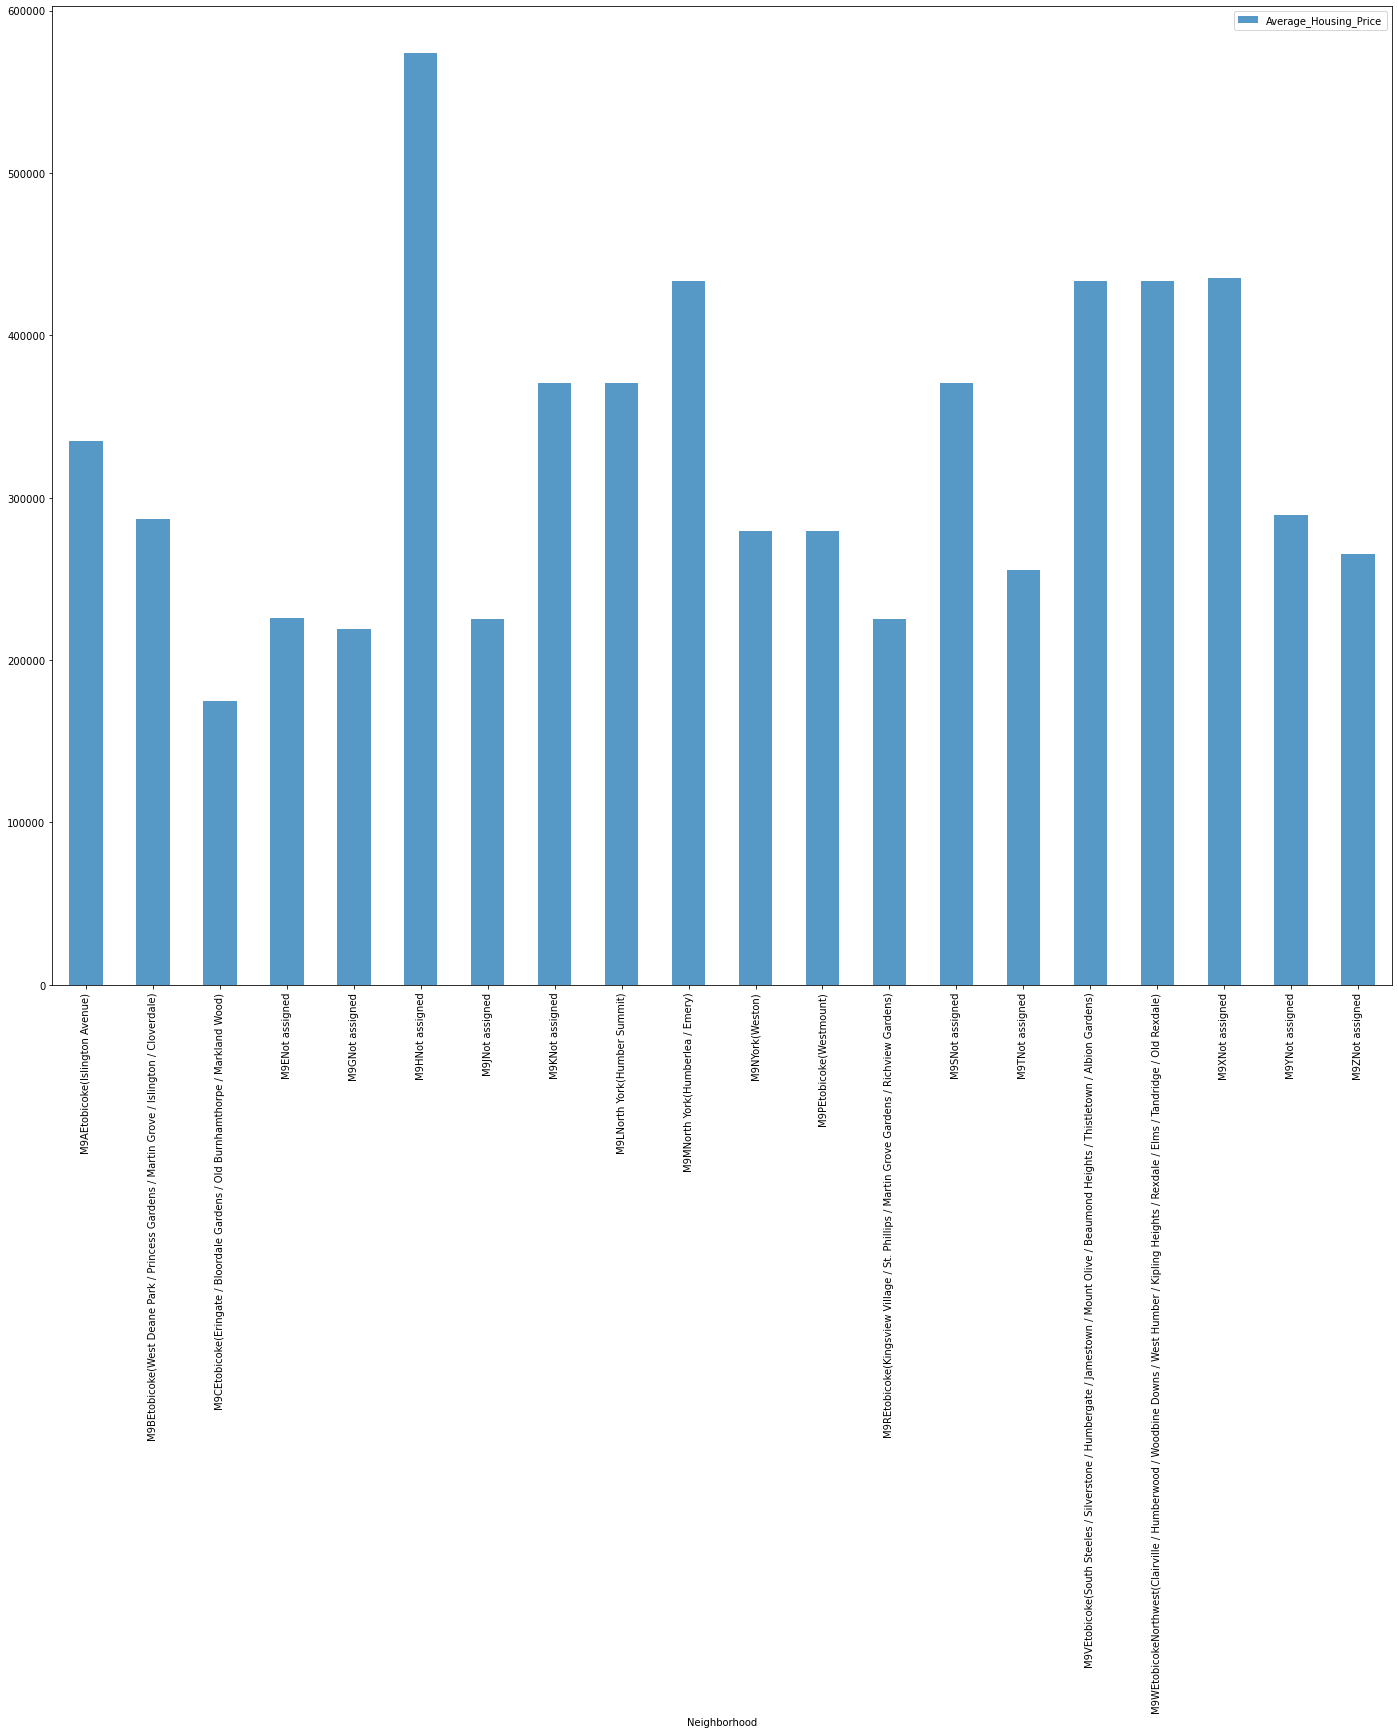

In [55]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [56]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [59]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8
                                                           ]})

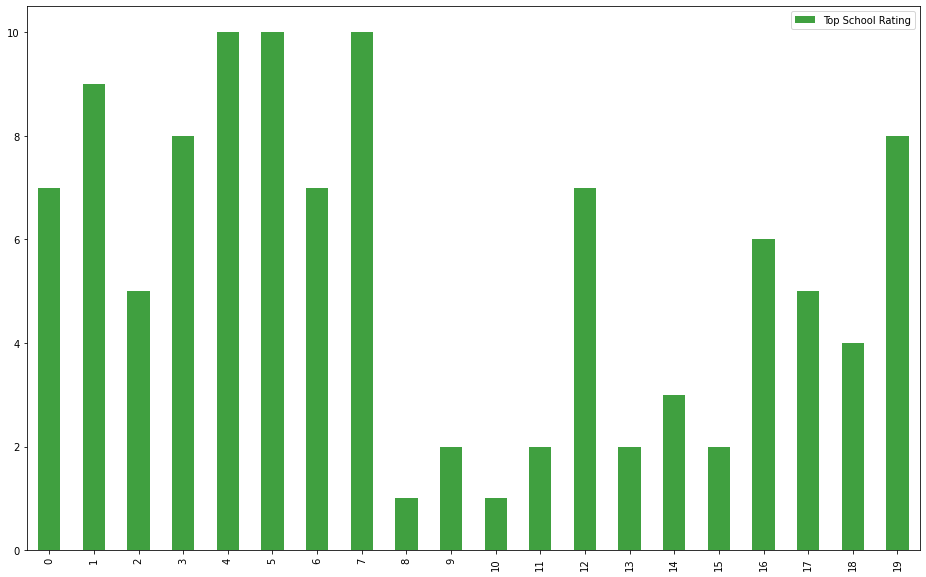

In [60]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.